# Multi-Class Classification w/ Convolutional Neural Network

In [2]:
import csv
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

# Download and preprocess the data

In [18]:
sign_mnist_train = pd.read_csv("https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR")
#sign_mnist_train.drop(0,1)
sign_mnist_train.to_csv("C:/Users/Alexl/OneDrive/Documents/Work/Portfolio Projects/CNN with Multi-Class Classification - Sign Language MNIST Dataset/sign_mnist_train.csv", index = False)

sign_mnist_test = pd.read_csv("https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg")
#sign_mnist_test.drop(0,1)
sign_mnist_test.to_csv("C:/Users/Alexl/OneDrive/Documents/Work/Portfolio Projects/CNN with Multi-Class Classification - Sign Language MNIST Dataset/sign_mnist_test.csv", index = False)

In [19]:
TRAINING_FILE = 'C:/Users/Alexl/OneDrive/Documents/Work/Portfolio Projects/CNN with Multi-Class Classification - Sign Language MNIST Dataset/sign_mnist_train.csv'
VALIDATION_FILE = 'C:/Users/Alexl/OneDrive/Documents/Work/Portfolio Projects/CNN with Multi-Class Classification - Sign Language MNIST Dataset/sign_mnist_test.csv'

with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

In [20]:
def parse_data_from_input(filename):
  """
  Parses the images and labels from a CSV file
  
  Args:
    filename (string): path to the CSV file
    
  Returns:
    images, labels: tuple of numpy arrays containing the images and labels
  """
  with open(filename) as file:
    csv_reader = csv.reader(file, delimiter=',')
    
    labels = []
    images = []

    # Skip header
    next(csv_reader, None)

    for row in csv_reader:
      label = row[0]
      image = row[1:]
      image = np.reshape(image, (28, 28))

      labels.append(label)
      images.append(image)
    
    labels = np.array(labels).astype('float')
    images = np.array(images).astype('float')

    return images, labels

training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


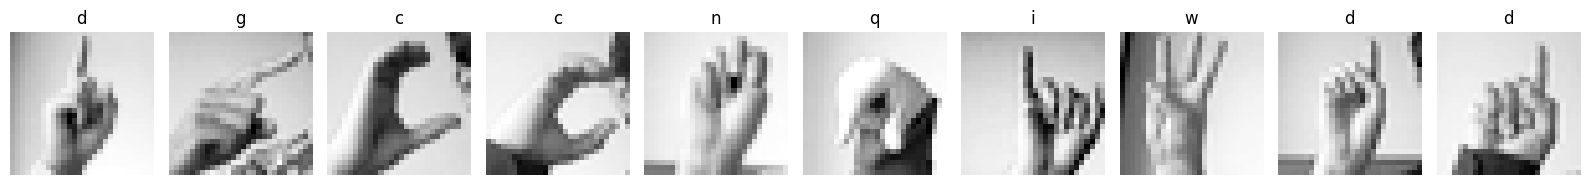

In [21]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

# Create ImageDataGenerator objects

In [22]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  """
  Creates the training and validation data generators
  
  Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  # Add another dimension to the data: (10000, 28, 28) --> (10000, 28, 28, 1)
  training_images = np.expand_dims(training_images, axis = -1)
  validation_images = np.expand_dims(validation_images, axis = -1)

  # Instantiate the training ImageDataGenerator class w/ Data Augmentation
  train_datagen = ImageDataGenerator(
      rescale = 1./255., 
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32)

  # Instantiate the validation ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale = 1./255)

  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32) 

  return train_generator, validation_generator

train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


# Convolutional Model

In [29]:
def create_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    # 26 classes
    tf.keras.layers.Dense(26, activation='softmax')])
  
  model.compile(optimizer = tf.optimizers.Adam(),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
                
  return model

In [30]:
# Save untrained model
model = create_model()

# Train model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 14s 16ms/step - loss: 2.6069 - accuracy: 0.1987 - val_loss: 1.6672 - val_accuracy: 0.4637
Epoch 2/15
858/858 [==============================] - 14s 16ms/step - loss: 1.6947 - accuracy: 0.4592 - val_loss: 0.9630 - val_accuracy: 0.6718
Epoch 3/15
858/858 [==============================] - 14s 16ms/step - loss: 1.2593 - accuracy: 0.5893 - val_loss: 0.6447 - val_accuracy: 0.7542
Epoch 4/15
858/858 [==============================] - 14s 16ms/step - loss: 1.0157 - accuracy: 0.6680 - val_loss: 0.5099 - val_accuracy: 0.8024
Epoch 5/15
858/858 [==============================] - 13s 16ms/step - loss: 0.8464 - accuracy: 0.7170 - val_loss: 0.4011 - val_accuracy: 0.8508
Epoch 6/15
858/858 [==============================] - 14s 16ms/step - loss: 0.7396 - accuracy: 0.7513 - val_loss: 0.4917 - val_accuracy: 0.8252
Epoch 7/15
858/858 [==============================] - 13s 16ms/step - loss: 0.6546 - accuracy: 0.7806 - val_loss: 0.2892 - val_accuracy:

# Plot the Accuracy/Loss for training and validation 

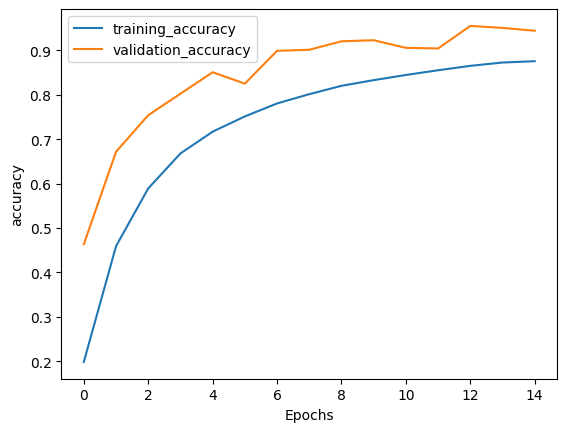

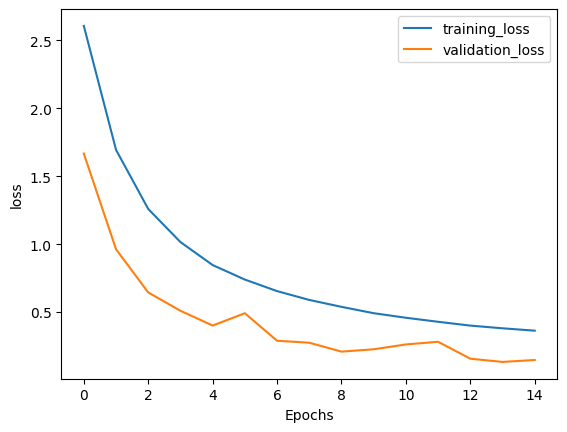

In [31]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([f'training_{metric}', f'validation_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")